# Programming Assignment 4: Sentiment analysis with SVM

In this programming assignment, we will revisit the problem of sensiment analysis, but using a different approach. Recall that the task is to predict the *sentiment* (positive or negative) of a single sentence taken from a review of a movie, restaurant, or product. The data set consists of 3000 labeled sentences, which we divide into a training set of size 2500 and a test set of size 500. Previously we found a logistic regression classifier. Today we will use a support vector machine.

Make sure the notebook is in the same folder that contains `full_set.txt`.

## 1. Load and preprocess data

In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our notation from lecture, we will change the negative review label to '-1'.

In [2]:
## Read in the data set.
with open("full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [3]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a very small list of stop words, but these are by no means comprehensive. Feel free to use something different; for instance, larger lists can easily be found on the web.

In [4]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., d}` where `d` is the size of our vocabulary. And each sentence is represented as a d-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn` (Note that this is the only time you can call an external function from scikit-learn). We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

Once we get the bag-of-words representation, append a '1' to the beginning of each vector to allow our linear classifier to learn a bias term.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)
data_mat = data_features.toarray()
print ('The original size: ',data_features.shape)

The original size:  (3000, 4500)


### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [6]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


## 2. Solving for soft-margin SVM


Recall that support vector machine (SVM) finds a linear decision boundary with the largest margin for a binary classification problem. Suppose we have a training dataset $\{(x_{1},y_1),...,(x_n,y_n)\}$
where $x_{i} \in \mathbb{R}^{d}$ are feature vectors and $y_i\in\{-1,+1\}$ are labels.  The linear classifier is parametrized by $\theta\in \mathbb{R}^{d}$ and $\theta_0\in\mathbb{R}$, and predicts +1 at a point $x$ if $\theta\cdot x+\theta_0>0$ and -1 otherwise. 

It turns out that the soft-margin SVM optimization is equivalent to the following unconstrained optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{hinge}}(y_i(\theta\cdot x_i+\theta_0))$$
where  $\ell_{\mathrm{hinge}}(t)=\max(0,1-t)$ is called the ``hinge loss,'' which takes value $1-t$ if $t<1$ and 0 otherwise. For example, $\ell_{\mathrm{hinge}}(-1)=2$, and $\ell_{\mathrm{hinge}}(2)=0$. 


It turns out that for gradient-based optimization, hinge loss may be difficult to deal with because it is not differentiable at point $t=1$. One solution is to use the ``smoothed version'' of hinge loss:

$$\ell_{\mathrm{smooth-hinge}}(t) = \begin{cases}
\frac{1}{2} - t      & \text{if} ~~ t \le 0, \\
\frac{1}{2} (1 - t)^2 & \text{if} ~~ 0 < t < 1, \\
0                      & \text{if} ~~ 1 \le t
\end{cases}$$


Thus, in the rest of the problem, we will consider the following optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$$

**Task P2:** Implement the hinge loss function and the smooth hinge loss function. Plot the function $\ell_{\mathrm{hinge}}(t)$ and $\ell_{\mathrm{smooth-hinge}}(t)$for $t\in[-5,5]$.

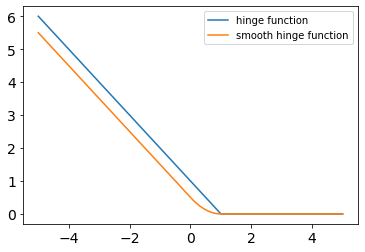

In [7]:
### STUDENT: Start of code ###
def hinge(t):
    return np.maximum(0, (1 - t))

def smooth_hinge(t):
    if t <= 0:
        return 0.5 - t
    elif 0 < t < 1:
        return 0.5 * (1. - t) ** 2.
    else:
        return 0.
    
def d_smooth_hinge(t):
    if t <= 0:
        return -1.
    elif 0 < t < 1:
        return t - 1.
    else:
        return 0.
    
x_list = np.linspace(-5, 5, 500)
hinge_list, smooth_list = [], []
for x in x_list:
    hinge_list.append(hinge(x))
    smooth_list.append(smooth_hinge(x))
plt.plot(x_list, hinge_list, label='hinge function')
plt.plot(x_list, smooth_list, label='smooth hinge function')
plt.legend(loc='best')
plt.show()
### End of code ###

**Task P5:** Let $f(\theta,\theta_0)= \|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$ be the objective function of the optimization problem we want to solve. Implement the function that obtains the partial derivative $\frac{\partial }{\partial \theta}f(\theta,\theta_0)$ and $\frac{\partial }{\partial \theta_0}f(\theta,\theta_0)$. Also, print out the output of the code that calculates the derivatives at $\theta=1$ and $\theta_0=1$ with $C=1$.

Hint: you need to calculate the partial derivative of the smoothed hinge loss for each data point separately, and add them together to obtain the result.

In [8]:
def weight_derivative(theta, theta0, C, feature_matrix, labels):
    # Input:
    # theta: weight vector theta, a numpy vector of dimension d
    # theta0: intercept theta0, a numpy vector of dimension 1
    # C: constant C
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d, each with value -1 or +1
    # Output:
    # Derivative of the cost function with respect to the weight theta, grad_theta
    # Derivative of the cost function with respect to the weight theta0, grad_theta0
        
    ## STUDENT: Start of code ###
    grad_theta, grad_theta0 = 0, 0
    for i in range(len(feature_matrix)):
        inside = labels[i] * (np.dot(feature_matrix[i], theta) + theta0)
        common_terms = d_smooth_hinge(inside) * labels[i]
        grad_theta += common_terms * feature_matrix[i]
        grad_theta0 += common_terms
    grad_theta *= C
    grad_theta0 *= C
    
    grad_theta += 2 * theta
    
    return grad_theta, grad_theta0
    # End of code ###

In [9]:
# STUDENT: PRINT THE OUTPUT AND COPY IT TO THE SOLUTION FILE
theta = np.ones(data_mat.shape[1]) # a weight of all 1s
theta0 = np.ones(1) # a number 1
C = 1
grad_theta, grad_theta0 = weight_derivative(theta, theta0, C, train_data, train_labels)

print (grad_theta[:10])
print (grad_theta0)


[ 2.  3.  3.  4.  3.  3. 38.  5.  2.  3.]
1250.0


**Task P6:**  For sentiment analysis data, choose a value for the trade-off parameter $C$. Report the training error at convergence and the testing error. 

Note:  you can just use the same gradient descent algorithm that we wrote in assignment 2, or use the adam_optimizer provided below.

Here is an [article](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c#:~:text=Adam%20%5B1%5D%20is%20an%20adaptive,for%20training%20deep%20neural%20networks.&text=The%20algorithms%20leverages%20the,learning%20rates%20for%20each%20parameter) on the Adam optimizer.

In [10]:
def objective(feature_matrix, labels, theta,theta0, C):
    score = (feature_matrix.dot(theta)+theta0)*labels
    return np.sum(theta**2)+C*np.sum([smooth_hinge(t) for t in score])

In [11]:
def adam_optimizer(feature_matrix, labels, initial_theta,initial_theta0, C, step_size=0.01, tolerence=0.01, b1=0.9, b2=0.999, eps=10**-8):
    # Gradient descent algorithm for logistic regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_theta: initial theta to start with, a numpy vector of dimension d
    # initial_theta0: initial theta0 to start with, a numpy vector of dimension 1
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Parameters by Adam optimizer
    # Output:
    # Weights obtained after convergence

    converged = False 
    m = np.zeros(len(initial_theta))
    v = np.zeros(len(initial_theta))
    m0 = np.zeros(1)
    v0 = np.zeros(1)
    theta = np.array(initial_theta) # current iterate
    theta0 = np.array(initial_theta0) # current iterate
    i = 0
    while not converged:
        # impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        i += 1
        grad_theta, grad_theta0  = weight_derivative(theta, theta0, C,feature_matrix, labels)
        
        m = (1 - b1) * grad_theta      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (grad_theta**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        theta = theta - step_size*mhat/(np.sqrt(vhat) + eps)
        
        m0 = (1 - b1) * grad_theta0      + b1 * m0  # First  moment estimate.
        v0 = (1 - b2) * (grad_theta0**2) + b2 * v0  # Second moment estimate.
        mhat0 = m0 / (1 - b1**(i + 1))    # Bias correction.
        vhat0 = v0 / (1 - b2**(i + 1))
        theta0 = theta0 - step_size*mhat0/(np.sqrt(vhat0) + eps)
        
        # Compute the gradient magnitude:
        
        gradient_magnitude = np.sqrt(np.sum(grad_theta**2))
        
        # Check the stopping condition to decide whether you want to stop the iterations
        
        if gradient_magnitude < tolerance:
            converged = True
        
        preds_train = model_predict(train_data,theta,theta0)

        ## Compute errors
        errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))

        print ("Iteration: ",i,"objective: ",objective(feature_matrix, labels, theta,theta0, C),"tr err: ",float(errs_train)/len(train_labels),"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        
    return(theta, theta0)

### End of code ###

In [12]:
def model_predict(feature_matrix,theta,theta0):
# Prediction made by SVM 
    
    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # theta: weight theta, a numpy vector of dimension d
    # theta0: weight theta0, a numpy vector of dimension 1
    # Output:
    # labels: predicted labels, a numpy vector of dimension n
    
    h =  feature_matrix.dot(theta)+theta0
    y_h = (h >= 0)*2-1
    
    return y_h    

In [13]:
# Initialize the weights, step size and tolerance
# Start of code
theta = np.ones(4500) # a weight of all 1s
theta0 = np.ones(1) # a number 1

initial_theta =  np.ones(data_mat.shape[1]) ## STUDENT: initialize theta
initial_theta0 = np.ones(1)   ## STUDENT: initialize theta0
C =  1 ## STUDENT: choose the C
step_size =  0.01 ## STUDENT: choose the step_size
tolerance =  0.07 ## STUDENT: choose the tolerance

# end of code

theta, theta0 = adam_optimizer(train_data, train_labels, initial_theta, initial_theta0, C, step_size, tolerance)
print(theta)
print(theta0)

Iteration:  1 objective:  18062.780117925668 tr err:  0.5 gradient_magnitude:  881.9659857386791
Iteration:  2 objective:  17873.964729424068 tr err:  0.5 gradient_magnitude:  881.6146137011254
Iteration:  3 objective:  17674.63403909325 tr err:  0.5 gradient_magnitude:  881.2105241348464
Iteration:  4 objective:  17469.781250121036 tr err:  0.5 gradient_magnitude:  880.7838262127175
Iteration:  5 objective:  17261.772586408806 tr err:  0.5 gradient_magnitude:  880.3451985835258
Iteration:  6 objective:  17051.921865916556 tr err:  0.5 gradient_magnitude:  879.8997037290503
Iteration:  7 objective:  16841.0370627796 tr err:  0.5 gradient_magnitude:  879.4501545665358
Iteration:  8 objective:  16629.6521405062 tr err:  0.5 gradient_magnitude:  878.9982828953936
Iteration:  9 objective:  16418.139378458018 tr err:  0.5 gradient_magnitude:  878.5452349470058
Iteration:  10 objective:  16206.769269370263 tr err:  0.5 gradient_magnitude:  878.0918114530543
Iteration:  11 objective:  15995.7

Iteration:  86 objective:  3105.4873565974203 tr err:  0.5 gradient_magnitude:  839.3047731078676
Iteration:  87 objective:  2972.5860589589133 tr err:  0.5 gradient_magnitude:  836.3944530082184
Iteration:  88 objective:  2841.0142316894717 tr err:  0.5 gradient_magnitude:  833.115642425371
Iteration:  89 objective:  2710.8540219918577 tr err:  0.5 gradient_magnitude:  829.4003717895358
Iteration:  90 objective:  2582.192898059686 tr err:  0.5 gradient_magnitude:  825.1063304140667
Iteration:  91 objective:  2455.145483499081 tr err:  0.5 gradient_magnitude:  820.0189730423557
Iteration:  92 objective:  2329.906297089172 tr err:  0.5 gradient_magnitude:  813.9917892493498
Iteration:  93 objective:  2206.7022133431524 tr err:  0.5 gradient_magnitude:  806.2445265837497
Iteration:  94 objective:  2085.8180974051174 tr err:  0.5 gradient_magnitude:  796.7969137780627
Iteration:  95 objective:  1967.5516024764565 tr err:  0.5 gradient_magnitude:  784.8632963285919
Iteration:  96 objective

Iteration:  168 objective:  361.8506723949703 tr err:  0.0328 gradient_magnitude:  68.7334440500655
Iteration:  169 objective:  360.3206298196401 tr err:  0.0324 gradient_magnitude:  67.13848355559114
Iteration:  170 objective:  358.8371391876026 tr err:  0.032 gradient_magnitude:  65.30478334861427
Iteration:  171 objective:  357.4015513927399 tr err:  0.0316 gradient_magnitude:  63.31142003950795
Iteration:  172 objective:  356.01464279584957 tr err:  0.0312 gradient_magnitude:  61.22497004364868
Iteration:  173 objective:  354.6763343915627 tr err:  0.0312 gradient_magnitude:  59.13115531442174
Iteration:  174 objective:  353.3856979360663 tr err:  0.0304 gradient_magnitude:  57.08873098063206
Iteration:  175 objective:  352.14121101618207 tr err:  0.0304 gradient_magnitude:  55.144606633233714
Iteration:  176 objective:  350.9407072874367 tr err:  0.03 gradient_magnitude:  53.324176095648376
Iteration:  177 objective:  349.7815419294682 tr err:  0.03 gradient_magnitude:  51.6739406

Iteration:  249 objective:  311.1449339973386 tr err:  0.0164 gradient_magnitude:  28.73948722563311
Iteration:  250 objective:  310.904618015853 tr err:  0.0164 gradient_magnitude:  28.536805976273243
Iteration:  251 objective:  310.6680795333962 tr err:  0.0164 gradient_magnitude:  28.33540042780005
Iteration:  252 objective:  310.4352388207446 tr err:  0.0164 gradient_magnitude:  28.136310985596552
Iteration:  253 objective:  310.20601538185406 tr err:  0.016 gradient_magnitude:  27.940012968646126
Iteration:  254 objective:  309.9803349305819 tr err:  0.0156 gradient_magnitude:  27.746400055259905
Iteration:  255 objective:  309.75814195030995 tr err:  0.0156 gradient_magnitude:  27.553139390475703
Iteration:  256 objective:  309.5393683937576 tr err:  0.0156 gradient_magnitude:  27.361176863089632
Iteration:  257 objective:  309.3239438346093 tr err:  0.0156 gradient_magnitude:  27.17266852944912
Iteration:  258 objective:  309.111799707778 tr err:  0.0156 gradient_magnitude:  26.

Iteration:  330 objective:  299.52670004687934 tr err:  0.0132 gradient_magnitude:  17.349864702310192
Iteration:  331 objective:  299.44584167627755 tr err:  0.0132 gradient_magnitude:  17.249223253770218
Iteration:  332 objective:  299.3659283937121 tr err:  0.0132 gradient_magnitude:  17.14911081136999
Iteration:  333 objective:  299.2869469767437 tr err:  0.0132 gradient_magnitude:  17.049526383542926
Iteration:  334 objective:  299.2088841382946 tr err:  0.0132 gradient_magnitude:  16.950467046695323
Iteration:  335 objective:  299.1317243399504 tr err:  0.0132 gradient_magnitude:  16.852063829006976
Iteration:  336 objective:  299.05545368765434 tr err:  0.0132 gradient_magnitude:  16.754560048519643
Iteration:  337 objective:  298.98005877885373 tr err:  0.0132 gradient_magnitude:  16.6576206409158
Iteration:  338 objective:  298.905527253425 tr err:  0.0132 gradient_magnitude:  16.56126602366422
Iteration:  339 objective:  298.8318472460428 tr err:  0.0132 gradient_magnitude:  

Iteration:  411 objective:  295.1952520362042 tr err:  0.0132 gradient_magnitude:  10.919915578646627
Iteration:  412 objective:  295.1619447742569 tr err:  0.0132 gradient_magnitude:  10.85990801700435
Iteration:  413 objective:  295.1289836799972 tr err:  0.0128 gradient_magnitude:  10.800228066143317
Iteration:  414 objective:  295.096365132998 tr err:  0.0128 gradient_magnitude:  10.740823338992147
Iteration:  415 objective:  295.0640855184306 tr err:  0.0128 gradient_magnitude:  10.681376807563247
Iteration:  416 objective:  295.03214111100544 tr err:  0.0128 gradient_magnitude:  10.62223022026661
Iteration:  417 objective:  295.00052821237045 tr err:  0.0128 gradient_magnitude:  10.563377611866843
Iteration:  418 objective:  294.96924317915597 tr err:  0.0128 gradient_magnitude:  10.504819547709957
Iteration:  419 objective:  294.93828242641973 tr err:  0.0128 gradient_magnitude:  10.44654223756595
Iteration:  420 objective:  294.9076424154292 tr err:  0.0128 gradient_magnitude: 

Iteration:  492 objective:  293.3564853416489 tr err:  0.0136 gradient_magnitude:  6.978763436373071
Iteration:  493 objective:  293.3419142537662 tr err:  0.0136 gradient_magnitude:  6.94043209912454
Iteration:  494 objective:  293.3274879416768 tr err:  0.0136 gradient_magnitude:  6.90234380920291
Iteration:  495 objective:  293.3132049482572 tr err:  0.0136 gradient_magnitude:  6.864442084794907
Iteration:  496 objective:  293.2990638321022 tr err:  0.0136 gradient_magnitude:  6.826727681592395
Iteration:  497 objective:  293.2850631675802 tr err:  0.0136 gradient_magnitude:  6.789199210271942
Iteration:  498 objective:  293.27120154465183 tr err:  0.0136 gradient_magnitude:  6.751855449826378
Iteration:  499 objective:  293.2574775686897 tr err:  0.0136 gradient_magnitude:  6.714695344725238
Iteration:  500 objective:  293.24388986029777 tr err:  0.0136 gradient_magnitude:  6.677717995914754
Iteration:  501 objective:  293.2304370551283 tr err:  0.0136 gradient_magnitude:  6.640922

Iteration:  573 objective:  292.5430031919662 tr err:  0.0136 gradient_magnitude:  4.429028731939322
Iteration:  574 objective:  292.5365140323952 tr err:  0.0136 gradient_magnitude:  4.403993670472464
Iteration:  575 objective:  292.53008922717197 tr err:  0.0136 gradient_magnitude:  4.3790847177210805
Iteration:  576 objective:  292.52372814373683 tr err:  0.0136 gradient_magnitude:  4.354301400943901
Iteration:  577 objective:  292.5174301566949 tr err:  0.0136 gradient_magnitude:  4.329643507106443
Iteration:  578 objective:  292.5111946473935 tr err:  0.0136 gradient_magnitude:  4.30511100091191
Iteration:  579 objective:  292.50502100357073 tr err:  0.0136 gradient_magnitude:  4.280703946888107
Iteration:  580 objective:  292.4989086190702 tr err:  0.0136 gradient_magnitude:  4.256422439079825
Iteration:  581 objective:  292.49285689361955 tr err:  0.0136 gradient_magnitude:  4.232266541012565
Iteration:  582 objective:  292.48686523266224 tr err:  0.0136 gradient_magnitude:  4.2

Iteration:  654 objective:  292.18069361604734 tr err:  0.0132 gradient_magnitude:  2.778971204686066
Iteration:  655 objective:  292.1778052823904 tr err:  0.0132 gradient_magnitude:  2.7627632685778205
Iteration:  656 objective:  292.17494579113963 tr err:  0.0132 gradient_magnitude:  2.746640106209442
Iteration:  657 objective:  292.1721148570921 tr err:  0.0132 gradient_magnitude:  2.730601175121567
Iteration:  658 objective:  292.1693121978698 tr err:  0.0132 gradient_magnitude:  2.7146459414409123
Iteration:  659 objective:  292.1665375320411 tr err:  0.0132 gradient_magnitude:  2.6987734188808195
Iteration:  660 objective:  292.1637905813534 tr err:  0.0132 gradient_magnitude:  2.6829794748092946
Iteration:  661 objective:  292.16107107161895 tr err:  0.0132 gradient_magnitude:  2.6672677599801644
Iteration:  662 objective:  292.1583787264157 tr err:  0.0132 gradient_magnitude:  2.651637859276237
Iteration:  663 objective:  292.15571324041025 tr err:  0.0132 gradient_magnitude: 

Iteration:  735 objective:  292.01974065869564 tr err:  0.0128 gradient_magnitude:  1.7168929404693243
Iteration:  736 objective:  292.0184596249977 tr err:  0.0128 gradient_magnitude:  1.7065291893257548
Iteration:  737 objective:  292.0171913708132 tr err:  0.0128 gradient_magnitude:  1.696224250404005
Iteration:  738 objective:  292.0159357683219 tr err:  0.0128 gradient_magnitude:  1.6859778247478003
Iteration:  739 objective:  292.0146926910853 tr err:  0.0128 gradient_magnitude:  1.6757896009220397
Iteration:  740 objective:  292.0134620140253 tr err:  0.0128 gradient_magnitude:  1.665659253577442
Iteration:  741 objective:  292.01224361340275 tr err:  0.0128 gradient_magnitude:  1.6555864428140576
Iteration:  742 objective:  292.01103736679767 tr err:  0.0128 gradient_magnitude:  1.6455708143818288
Iteration:  743 objective:  292.0098431530885 tr err:  0.0128 gradient_magnitude:  1.635612000706134
Iteration:  744 objective:  292.008660852433 tr err:  0.0128 gradient_magnitude:  

Iteration:  816 objective:  291.94835033317395 tr err:  0.012 gradient_magnitude:  1.0422620920891361
Iteration:  817 objective:  291.9477822593373 tr err:  0.012 gradient_magnitude:  1.035779174601751
Iteration:  818 objective:  291.9472198560691 tr err:  0.012 gradient_magnitude:  1.029335509511221
Iteration:  819 objective:  291.94666306721615 tr err:  0.012 gradient_magnitude:  1.022930912194193
Iteration:  820 objective:  291.94611183814897 tr err:  0.012 gradient_magnitude:  1.0165646231624739
Iteration:  821 objective:  291.9455661138153 tr err:  0.012 gradient_magnitude:  1.010236628900668
Iteration:  822 objective:  291.9450258410601 tr err:  0.012 gradient_magnitude:  1.0039447617818003
Iteration:  823 objective:  291.94449096666665 tr err:  0.012 gradient_magnitude:  0.9976817814590482
Iteration:  824 objective:  291.9439614371836 tr err:  0.012 gradient_magnitude:  0.9914565099147423
Iteration:  825 objective:  291.94343719966406 tr err:  0.012 gradient_magnitude:  0.985268

Iteration:  897 objective:  291.91672421522867 tr err:  0.012 gradient_magnitude:  0.6253134201076133
Iteration:  898 objective:  291.9164731571873 tr err:  0.012 gradient_magnitude:  0.6213430904647864
Iteration:  899 objective:  291.91622463036106 tr err:  0.012 gradient_magnitude:  0.6173965636596457
Iteration:  900 objective:  291.9159786096177 tr err:  0.012 gradient_magnitude:  0.6134736911312134
Iteration:  901 objective:  291.9157350700769 tr err:  0.012 gradient_magnitude:  0.6095743397788844
Iteration:  902 objective:  291.9154939871074 tr err:  0.012 gradient_magnitude:  0.6056983904076482
Iteration:  903 objective:  291.91525533632466 tr err:  0.012 gradient_magnitude:  0.6018457353755184
Iteration:  904 objective:  291.91501909358794 tr err:  0.012 gradient_magnitude:  0.598016275701592
Iteration:  905 objective:  291.9147852349977 tr err:  0.012 gradient_magnitude:  0.594209917904813
Iteration:  906 objective:  291.9145537368933 tr err:  0.012 gradient_magnitude:  0.59042

Iteration:  978 objective:  291.9028044226873 tr err:  0.012 gradient_magnitude:  0.37099111421285536
Iteration:  979 objective:  291.9026946761559 tr err:  0.012 gradient_magnitude:  0.36858199889086507
Iteration:  980 objective:  291.9025860562232 tr err:  0.012 gradient_magnitude:  0.36618794276397626
Iteration:  981 objective:  291.90247855118565 tr err:  0.012 gradient_magnitude:  0.3638098265379786
Iteration:  982 objective:  291.9023721496782 tr err:  0.012 gradient_magnitude:  0.3614494754924099
Iteration:  983 objective:  291.90226684063515 tr err:  0.012 gradient_magnitude:  0.35910381766092986
Iteration:  984 objective:  291.902162612977 tr err:  0.012 gradient_magnitude:  0.35677270680154527
Iteration:  985 objective:  291.9020594556109 tr err:  0.012 gradient_magnitude:  0.3544561324537784
Iteration:  986 objective:  291.9019573577792 tr err:  0.012 gradient_magnitude:  0.35215393765006836
Iteration:  987 objective:  291.90185630884037 tr err:  0.012 gradient_magnitude:  0

Iteration:  1058 objective:  291.896809089944 tr err:  0.012 gradient_magnitude:  0.2194641305090703
Iteration:  1059 objective:  291.89676145692675 tr err:  0.012 gradient_magnitude:  0.21801756002308761
Iteration:  1060 objective:  291.89671432538216 tr err:  0.012 gradient_magnitude:  0.21658027238183306
Iteration:  1061 objective:  291.8966676902262 tr err:  0.012 gradient_magnitude:  0.21515221018832648
Iteration:  1062 objective:  291.89662154642485 tr err:  0.012 gradient_magnitude:  0.21373331631367917
Iteration:  1063 objective:  291.8965758889941 tr err:  0.012 gradient_magnitude:  0.21232353394109665
Iteration:  1064 objective:  291.89653071299864 tr err:  0.012 gradient_magnitude:  0.2109228066084271
Iteration:  1065 objective:  291.89648601355213 tr err:  0.012 gradient_magnitude:  0.20953107824544867
Iteration:  1066 objective:  291.89644178581636 tr err:  0.012 gradient_magnitude:  0.20814829320198627
Iteration:  1067 objective:  291.89639802500085 tr err:  0.012 gradien

Iteration:  1138 objective:  291.8942344141934 tr err:  0.012 gradient_magnitude:  0.12883104844934587
Iteration:  1139 objective:  291.8942142866365 tr err:  0.012 gradient_magnitude:  0.12797056678606275
Iteration:  1140 objective:  291.89419437869924 tr err:  0.012 gradient_magnitude:  0.12711561102768748
Iteration:  1141 objective:  291.8941746880916 tr err:  0.012 gradient_magnitude:  0.12626616185685802
Iteration:  1142 objective:  291.89415521254693 tr err:  0.012 gradient_magnitude:  0.12542220106953955
Iteration:  1143 objective:  291.89413594982113 tr err:  0.012 gradient_magnitude:  0.12458371030959135
Iteration:  1144 objective:  291.8941168976926 tr err:  0.012 gradient_magnitude:  0.12375066999574023
Iteration:  1145 objective:  291.894098053962 tr err:  0.012 gradient_magnitude:  0.1229230585097441
Iteration:  1146 objective:  291.894079416452 tr err:  0.012 gradient_magnitude:  0.1221008516838166
Iteration:  1147 objective:  291.89406098300725 tr err:  0.012 gradient_ma

Iteration:  1218 objective:  291.89316158775273 tr err:  0.012 gradient_magnitude:  0.07510453551941536
Iteration:  1219 objective:  291.8931533720587 tr err:  0.012 gradient_magnitude:  0.07459610757843944
Iteration:  1220 objective:  291.89314524990925 tr err:  0.012 gradient_magnitude:  0.07409102568560408
Iteration:  1221 objective:  291.8931372202924 tr err:  0.012 gradient_magnitude:  0.07358926827704833
Iteration:  1222 objective:  291.8931292822061 tr err:  0.012 gradient_magnitude:  0.07309081396134945
Iteration:  1223 objective:  291.89312143465895 tr err:  0.012 gradient_magnitude:  0.07259564149215121
Iteration:  1224 objective:  291.8931136766698 tr err:  0.012 gradient_magnitude:  0.07210372974244933
Iteration:  1225 objective:  291.89310600726753 tr err:  0.012 gradient_magnitude:  0.0716150576821131
Iteration:  1226 objective:  291.89309842549085 tr err:  0.012 gradient_magnitude:  0.07112960436119578
Iteration:  1227 objective:  291.89309093038884 tr err:  0.012 gradie

In [14]:
# STUDENT: copy the output of this section to the solution file

## Get predictions on training and test data
preds_train = model_predict(train_data,theta,theta0)
preds_test = model_predict(test_data,theta,theta0)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.012
Test error:  0.136


**Task P7:**  List 4 example sentences that are correctly classified by SVM, and 4 example sentences that are  incorrectly classified by SVM. Explain what you have found.

In [15]:
# STUDENT: your code here
incorrect_sent = []
correct_sent = []
correct, incorrect = 0, 0
i = np.random.randint(500)
while (correct < 4) or (incorrect < 10):
    if ((preds_test[i] > 0.) != (test_labels[i] > 0.)): #error
        if incorrect < 10:
            incorrect_sent.append((test_inds[i], test_data[i], preds_test[i], test_labels[i]))
            incorrect += 1
    else: #correct prediction
        if correct < 4:
            correct_sent.append((test_inds[i], test_data[i], preds_test[i], test_labels[i]))
            correct += 1
    i = np.random.randint(500)
    


print("__________________________________")
print("correctly classified sentences:")
print("----------------------------------")
for sent in correct_sent:
    print(sentences[sent[0]])
    print("labeled as:", sent[2], "actually:", sent[3])
    print(" ")
    
print('__________________________________')
print("incorrectly classified sentences:")
print("----------------------------------")
for sent in incorrect_sent:
    print(sentences[sent[0]])
    print("labeled as:", sent[2], "actually:", sent[3])
    print(" ")

__________________________________
correctly classified sentences:
----------------------------------
All in all its an insult to one's intelligence and a huge waste of money.  
labeled as: -1 actually: -1
 
I'm pleased.
labeled as: 1 actually: 1
 
If this premise sound stupid, that's because it is.  
labeled as: -1 actually: -1
 
The one down note is the ventilation could use some upgrading.
labeled as: -1 actually: -1
 
__________________________________
incorrectly classified sentences:
----------------------------------
Overall, I don't think that I would take my parents to this place again because they made most of the similar complaints that I silently felt too.
labeled as: 1 actually: -1
 
Overall, I don't think that I would take my parents to this place again because they made most of the similar complaints that I silently felt too.
labeled as: 1 actually: -1
 
The warmth it generates is in contrast to its austere backdrop.  
labeled as: -1 actually: 1
 
All in all, I'd expecte

## Observations
Of the incorrectly labelled sentences, there were a few observations to be made. Most of the false positives contain some simple words that have greater weight than the neagtive obscure words. Words like "much", "more", and "good" showed up in the false positives where a customer described the experience they expected. This is because only a bag of words was considered apposed to looking at sentence structure and context. Similarly the false negatives contained words like "almost" or "hard". This echoes the lack of context. Another factor for some of the mislabeled sentences were the size of those sentences. few words led to very binary results that could increase the error of the sentence.